[Real or Fake] Fake JobPosting Prediction

In [ ]:
import os
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline
pd.reset_option("display.max_rows")

In [ ]:
# Set-up
drive.mount('/content/drive/')
os.chdir("/content/drive/My Drive/colab")
! pip install kaggle
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

Mounted at /content/drive/


In [ ]:
# Load Dataset
if not os.path.isfile('real-or-fake-fake-jobposting-prediction.zip'):
  ! kaggle datasets download shivamb/real-or-fake-fake-jobposting-prediction
if not os.path.isfile('fake_job_postings.csv'):
  !unzip real-or-fake-fake-jobposting-prediction.zip

In [ ]:
!ls

fake_job_postings.csv  real-or-fake-fake-jobposting-prediction.zip
kaggle.json	       Stack_Overflow_Tag_Predictor.ipynb


In [ ]:
# Reading Data
df = pd.read_csv('fake_job_postings.csv')
print('No. of Datapoints =',df.shape[0])
print('No. of Features =', df.shape[1])
df[5:9]

No. of Datapoints = 17880
No. of Features = 18


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
5,6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0
6,7,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0
7,8,Lead Guest Service Specialist,"US, CA, San Francisco",NaN,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,NaN,NaN,NaN,NaN,NaN,0
8,9,HP BSM SME,"US, FL, Pensacola",NaN,NaN,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,NaN,0,1,1,Full-time,Associate,NaN,Information Technology and Services,NaN,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [ ]:
numerical_features = [df.columns[i] for i in range(len(df.columns)) if (df[df.columns[i]].dtype=='int64')]
print('Numerical features : ',numerical_features)

Numerical features :  ['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']



<h3>The dataset has 17880 job postings, with 18 features. Out of these 18 features, only 5 are numerical and rest of them are text based.</h3>



 No. of negative points : 17014 (95.16%)
 No. of positive points :   866 (4.84%)  



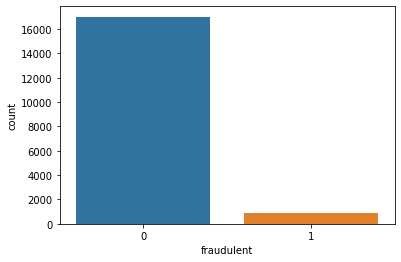

In [ ]:
# Checking if data is balanced
print(f''' No. of negative points : {df['fraudulent'].value_counts()[0]} ({ np.round( df['fraudulent'].value_counts()[0]/df.shape[0] * 100, 2)  }%)''')
print(f''' No. of positive points :   {df['fraudulent'].value_counts()[1]} ({np.round(100 - df['fraudulent'].value_counts()[0]/df.shape[0] *100, 2)}%)  \n''')
plt.figure()
sns.countplot(df['fraudulent'])
plt.show()

<h3>The dataset is Highly Imbalanced</h3>

In [ ]:
# features having NA items
na_features = [feature for feature in df.columns if df[str(feature)].isnull().values.any()]
not_na_features = [feature for feature in df.columns if feature not in na_features]
print(f'No. of features with no missing values= {len(not_na_features)}')
print(f'These are : {not_na_features}\n')

print(f'No. of features with missing values   = {len(na_features)}')
print(f'These are : {na_features}')
# len(na_features) + len(not_na_features)

No. of features with no missing values= 6
These are : ['job_id', 'title', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']

No. of features with missing values   = 12
These are : ['location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']


                Feature   NA %
0            department  64.58
1          requirements  15.07
2   required_experience  39.43
3           description   0.01
4       employment_type  19.41
5              location   1.94
6       company_profile  18.50
7          salary_range  83.96
8              benefits  40.32
9    required_education  45.33
10             function  36.10
11             industry  27.42


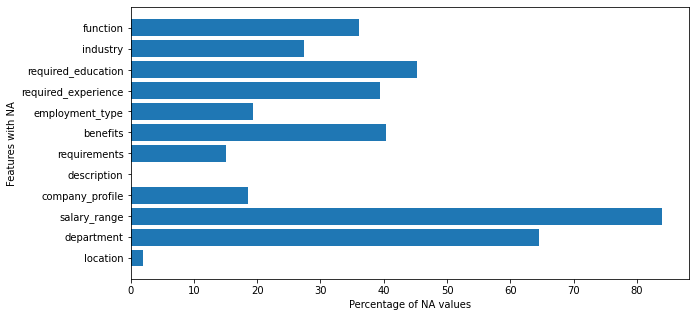

In [ ]:
# % of missing values
na_percentage = [np.round(df[feature].isnull().values.sum()/df.shape[0]*100, 2) for feature in na_features]
print(pd.DataFrame(set(zip(na_features, na_percentage)), columns=['Feature', 'NA %']))
fig = plt.figure(figsize = (10, 5))
plt.barh(na_features, na_percentage)
plt.ylabel('Features with NA')
plt.xlabel('Percentage of NA values')
plt.show()

<h4>Features 'salary-range' has 84%, and 'department' has 65% missing values.

While 'description' has only 1 missing value and 'location' has 2% missing values.

We can completely drop feature salary-range and for 'description' and 'location' only drop the rows with values missing.</h4>

In [ ]:
# Analysing feature 'salary_range' with 84% missing values
p =  re.compile('[0-9]+-[0-9]+', re.IGNORECASE)


sal_range_fraud_df = df[['salary_range', 'fraudulent']].dropna()[  df[['salary_range', 'fraudulent']].dropna()['salary_range'].apply(lambda x: p.match(str(x))!=None)  ]
sal_range_fraud_df['low_sal'] = sal_range_fraud_df['salary_range'].apply(lambda x: float(x.split('-')[0]))
sal_range_fraud_df['high_sal'] = sal_range_fraud_df['salary_range'].apply(lambda x: float(x.split('-')[1]))
sal_range_fraud_df['mean_sal'] = sal_range_fraud_df['salary_range'].apply(lambda x:   (float(x.split('-')[0]) + float(x.split('-')[1])) / 2) 

c = sal_range_fraud_df.columns    # reaaraing columns
sal_range_fraud_df = sal_range_fraud_df[[c[0], c[2], c[3], c[4], c[1]]]

sal_range_fraud_df.head()

,salary_range,low_sal,high_sal,mean_sal,fraudulent
6,20000-28000,20000.0,28000.0,24000.0,0
10,100000-120000,100000.0,120000.0,110000.0,0
15,120000-150000,120000.0,150000.0,135000.0,0
23,100000-120000,100000.0,120000.0,110000.0,0
31,50000-65000,50000.0,65000.0,57500.0,0


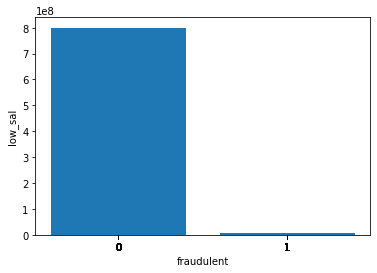

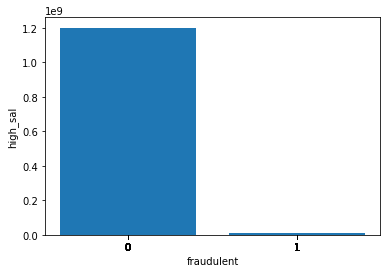

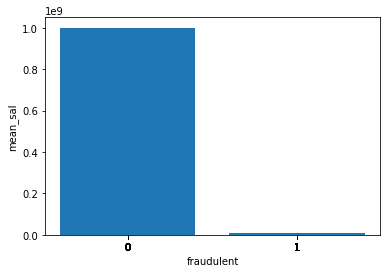

In [ ]:
for feature in sal_range_fraud_df.columns[1:-1]:
  plt.bar(sal_range_fraud_df['fraudulent'], sal_range_fraud_df[str(feature)])
  plt.xlabel('fraudulent')
  plt.xticks(sal_range_fraud_df['fraudulent'])
  plt.ylabel(str(feature))
  plt.show()

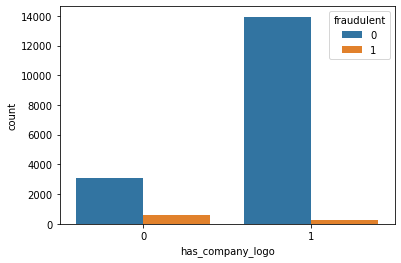

In [ ]:
# Analysing 'has_company_logo'
sns.countplot(df['has_company_logo'], hue=df['fraudulent'])

<h4>We can conclude that given that the company has no logo, there is a high chance of it being fraudulent. On the other hand, fraud rates are very less if company has a logo.
Also it does not have any missing values.
Thus, 'has_company_logo' is an important feature for classification.

But this can be misleading since the data is highly imbalanced</h4>

telecommuting
No. of records with telecommuting =0 : 17113; Fraud % : 4.6864956465844685%
No. of records with telecommuting=1 : 767; Fraud % : 8.34419817470665%


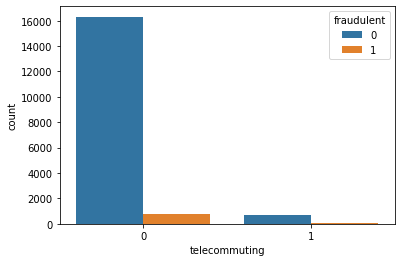

has_company_logo
No. of records with has_company_logo =0 : 3660; Fraud % : 15.92896174863388%
No. of records with has_company_logo=1 : 14220; Fraud % : 1.990154711673699%


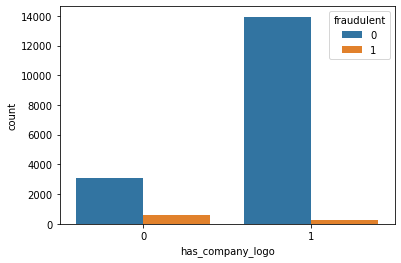

has_questions
No. of records with has_questions =0 : 9088; Fraud % : 6.778169014084508%
No. of records with has_questions=1 : 8792; Fraud % : 2.843494085532302%


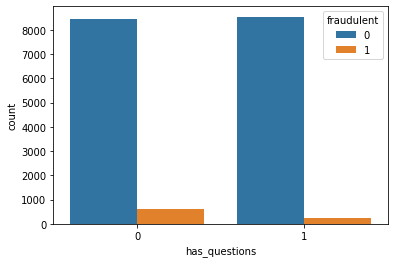

In [ ]:
# Analysing numerical features '
for feature in numerical_features[1:]:
  if feature not in na_features and feature not in ['job_id', 'fraudulent']:
    plt.figure()
    print(feature)
    sns.countplot(df[feature], hue=df['fraudulent'])
    print(f'''No. of records with {feature} =0 : {df[feature].value_counts()[0]}; Fraud % : {(df.groupby(feature)['fraudulent'].mean()*100)[0]}%''')
    print(f'''No. of records with {feature}=1 : {df[feature].value_counts()[1]}; Fraud % : {(df.groupby(feature)['fraudulent'].mean()*100)[1]}%''')
    plt.show()

Following observations can be made from above plots :

1. telecommuting : Probability/Chance of a datapoint being fraud is 2 times higher when this feature's value is 1 comapared to when it is 0.

2. has_company_logo : Chance of a datapoint being fraud is 7 times higher when this feature's value is 0 comapared to when it is 1.

3. has_questions : Chance of a datapoint being fraud is 3 times higher when this feature's value is 0 comapared to when it is 1.

Out of above three numerical features, the feature 'has_company_logo' is a major deciding factor for predicting fraud or not fraud.

17880

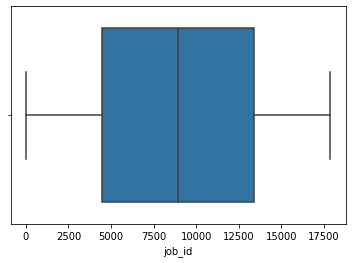

In [ ]:
# Analysing feature job_id
sns.boxplot(df['job_id'])
len(df['job_id'].unique())

feature 'job_id' is only for unique identification of data points and can be removed for classficiation

In [ ]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [ ]:
# Analysing feature 'function'
func_fraud_df = df[['function', 'fraudulent']].dropna()
print(f'''No. of datapoints with no missing values of function: {func_fraud_df.shape[0]}''')
print(f'''No. of unique function values: {len(func_fraud_df['function'].unique())}\n''')
func_fraud_df.head(5)

No. of datapoints with no missing values of function: 11425
No. of unique function values: 37



,function,fraudulent
0,Marketing,0
1,Customer Service,0
3,Sales,0
4,Health Care Provider,0
6,Management,0


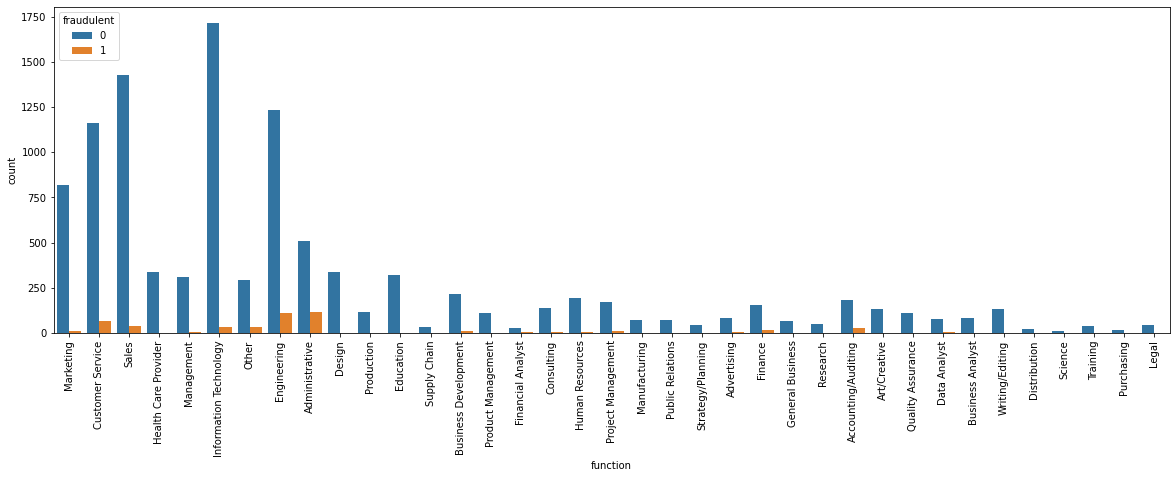

,Count,Fraud Rate (in %)
function,,
Writing/Editing,132.0,0.00
Legal,47.0,0.00
Product Management,114.0,0.00
Production,116.0,0.00
Purchasing,15.0,0.00
Quality Assurance,111.0,0.00
Training,38.0,0.00
Science,14.0,0.00
Supply Chain,36.0,0.00


In [ ]:
plt.figure(figsize=(20,6))
sns.countplot(func_fraud_df['function'], hue=func_fraud_df['fraudulent'])
plt.xticks(rotation=90)
plt.show()

def f(x):
  d = {}
  d['Count'] = x['function'].count()
  d['Fraud Rate (in %)'] = np.round(x['fraudulent'].mean()*100, 2)
  return pd.Series(d, index=['Count', 'Fraud Rate (in %)'])


func_fraud_df.groupby('function').apply(f).sort_values(by = 'Fraud Rate (in %)', ascending = 'False')

<h3>Functions like <b>Writing/Editing, Research, Science</b> and some others have zero fraud rates whereas there exist functions like <b>Administrative (18.8%), Financial Analyst (15%), Accounting/Auditing</b> (13.68%) with high fraud rates.</h3>

In [ ]:
# Analysing feature location
print(f'''No. of unique location values = {len(df['location'].dropna().unique())}''')
print(f'''No. of points of location excluding (na) = {len(df['location'].dropna())}\n\n''')
print('Top 10 location values with maximum counts\n\n')
df['location'].dropna().value_counts().sort_values(ascending=False)[:25]


No. of unique location values = 3105
No. of points of location excluding (na) = 17534


Top 10 location values with maximum counts




GB, LND, London          718
US, NY, New York         658
US, CA, San Francisco    472
GR, I, Athens            464
US, ,                    339
US, TX, Houston          269
US, IL, Chicago          255
US, DC, Washington       251
DE, BE, Berlin           221
NZ, N, Auckland          218
US, CA, Los Angeles      185
GB, , London             179
US, TX, Austin           174
US, CA, San Diego        164
GB, ,                    138
US, GA, Atlanta          135
GB, LND,                 131
US, OR, Portland         131
CA, ON, Toronto          123
US, MA, Boston           117
US, PA, Philadelphia     114
US, MI, Detroit          112
US, NY, Brooklyn         109
US, TX, Dallas           104
US, OH, Cleveland         95
Name: location, dtype: int64


Top 25 most frequent locations along with their Fraud rates

                       Count  Fraud %
location                             
GB, LND, London        718.0     0.28
US, NY, New York       658.0     3.04
US, CA, San Francisco  472.0     2.33
GR, I, Athens          464.0     0.00
US, ,                  339.0     8.26
US, TX, Houston        269.0    34.20
US, IL, Chicago        255.0     1.57
US, DC, Washington     251.0     0.80
DE, BE, Berlin         221.0     0.00
NZ, N, Auckland        218.0     0.00
US, CA, Los Angeles    185.0    12.43
GB, , London           179.0     0.56
US, TX, Austin         174.0     4.02
US, CA, San Diego      164.0     0.61
GB, ,                  138.0     0.72
US, GA, Atlanta        135.0     3.70
US, OR, Portland       131.0     0.76
GB, LND,               131.0     1.53
CA, ON, Toronto        123.0     4.88
US, MA, Boston         117.0     1.71
US, PA, Philadelphia   114.0     4.39
US, MI, Detroit        112.0     0.89
US, NY, Brooklyn       109

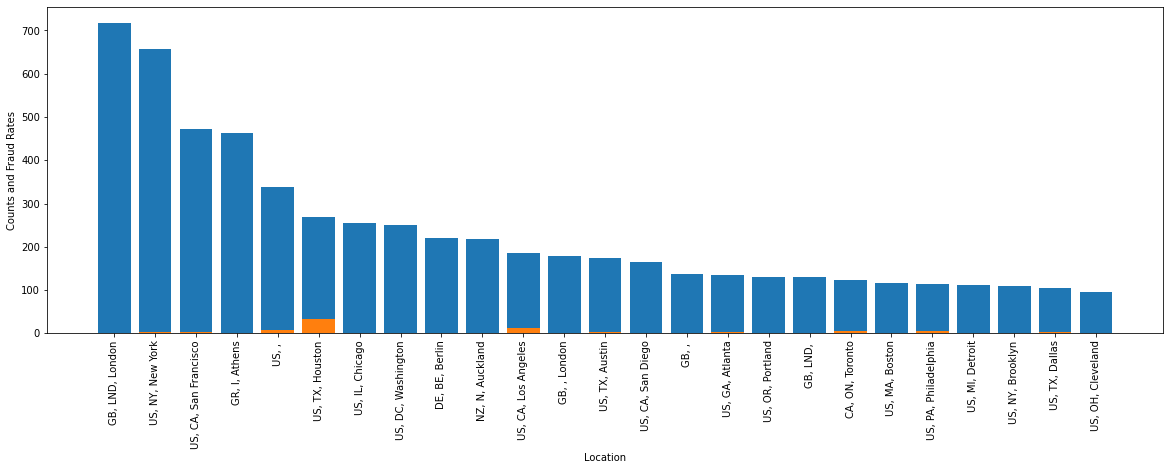

In [ ]:
loc_fraud_df = df[['location', 'fraudulent']].dropna()


def g(x):
  d = {}
  d['Count'] = x['location'].count()
  d['Fraud %'] = np.round(x['fraudulent'].mean()*100, 2)
  return pd.Series(d, index=['Count', 'Fraud %'])

print(f'\nTop 25 most frequent locations along with their Fraud rates\n')
top_25_loc_df = loc_fraud_df.groupby('location').apply(g).sort_values(by = 'Count', ascending = 'True').tail(25).iloc[::-1]
print(top_25_loc_df)
plt.figure(figsize=(20,6))
plt.bar(top_25_loc_df.index, top_25_loc_df['Count'])
plt.bar(top_25_loc_df.index, top_25_loc_df['Fraud %'])
# sns.barplot(x= top_25_loc_df.index, y=top_25_loc_df['Count'])
plt.xticks(rotation=90)
plt.xlabel('Location')
plt.ylabel('Counts and Fraud Rates')
plt.show()
# sns.barplot(x=top_25_loc_df['Fraud %'])


Locations like US, TX, Houston (Fraud % = 35) and US, CA, Los Angeles (Fraud % = 12) have high fraud rates.

Locations like GR, I, Athens;  DE, BE, Berlin; NZ, N, Auckland have zero fraud rates in the given data.

In [ ]:
print(numerical_features)
print(na_features)

['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']
['location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']


In [ ]:
# Analysing feature department
emp_type_fraud_df = df[['employment_type', 'fraudulent']].dropna()
emp_type_fraud_df.groupby('employment_type')['fraudulent'].mean()

employment_type
Contract     0.028871
Full-time    0.042169
Other        0.066079
Part-time    0.092848
Temporary    0.008299
Name: fraudulent, dtype: float64